**Authors**: Carayon Chloé - Taillieu Victor

**Date**: 01/12/2020

---
# LAB1 Machine Learning: Linear Regression from Scratch
---

## Introduction

The goal of this first lab is to build our own linear regression model by implementing gradient descent from scratch using linear algebra.
And then compare our results to a linear model generated by **Scikit-Learn** library and the normal equation.

In [1]:
import pandas as pd
!pip install xlrd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


## Dataset understanding

Let's load and take a look at the Combined Cycle Power Plant (CCPP) dataset.  
It can be found here: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

In [2]:
excel_df1 = pd.read_excel('data/CCPP.xlsx', sheet_name='Sheet1')
excel_df2 = pd.read_excel('data/CCPP.xlsx', sheet_name='Sheet2')
excel_df3 = pd.read_excel('data/CCPP.xlsx', sheet_name='Sheet3')
excel_df4 = pd.read_excel('data/CCPP.xlsx', sheet_name='Sheet4')
excel_df5 = pd.read_excel('data/CCPP.xlsx', sheet_name='Sheet5')
df = pd.concat([excel_df1, excel_df2, excel_df3,excel_df4,excel_df5])

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [3]:
df.describe()

,AT,V,AP,RH,PE
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


The dataset is composed of 5 columns:
- AT: ambient temperature (°C)
- V: vacuum (cm.Hg)
- AP: ambient pressure (mbar)
- RH: relative humidity (%)
- PE: energy output (MW)

We want to predict PE, which is given, so this is a supervised machine learning problem.

Before getting to the visualization part, let's quickly check if there are missing values:

In [4]:
print("Number of missing values:", df.isnull().sum().sum())

Number of missing values: 0


There is no missing value in this dataset.

### Data visualization

We then plot the relationships between our variables AT, V, AP, RH and PE.

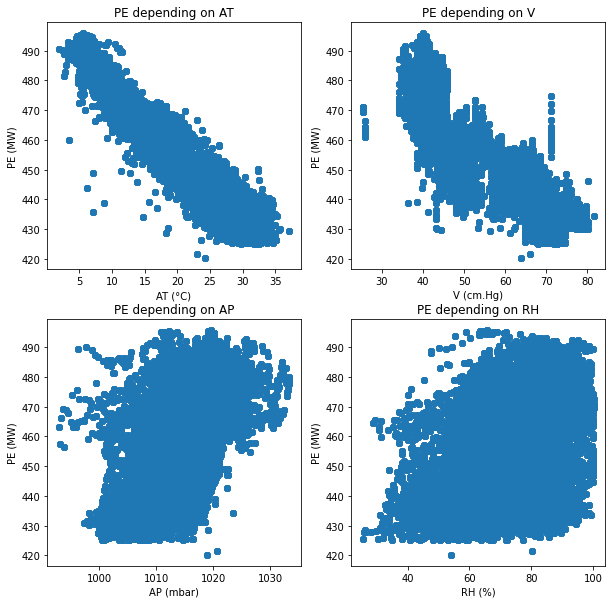

In [5]:
plt.subplots(2,2,figsize=(10,10))

plt.subplot(221)
plt.title("PE depending on AT")
plt.scatter(df.AT, df.PE)
plt.xlabel("AT (°C)")
plt.ylabel("PE (MW)")

plt.subplot(222)
plt.title("PE depending on V")
plt.scatter(df.V, df.PE)
plt.xlabel("V (cm.Hg)")
plt.ylabel("PE (MW)")

plt.subplot(223)
plt.title("PE depending on AP")
plt.scatter(df.AP, df.PE)
plt.xlabel("AP (mbar)")
plt.ylabel("PE (MW)")

plt.subplot(224)
plt.title("PE depending on RH")
plt.scatter(df.RH, df.PE)
plt.xlabel("RH (%)")
plt.ylabel("PE (MW)")

plt.show()

* For PE depending on AT:  
The plot has the shape of a linear pattern. Points are spread from up left to down right, 
it indicates a negative relationship between AT and PE. PE decreases as AT increases.

* For PE depending on V:  
The points are more scattered and follow a downhill pattern. We have a negative relationship
between PE and V.

* For PE depending on AP:  
The data are scattered but seem to follow an uphill pattern, as we move from down left to up right, 
it indicates a positive relationship between AP and PE. 

* For PE depending on RH:  
The data seem to follow an uphill pattern, but as they are very scattered, we can't be certain that there 
is a relationship between PE and RH. 


As it seems to be some linear relationships between variables AT, V, RH, AP and PE,
we can implement a linear model to predict PE in function of the other variables.

## 1. Linear Regression from Scratch

Firstly, we have to implement the following functions to build our model:
- normalizeFeatures(params)
- costFunction(params)
- gradientDescent(params)

The parameters we use are:

- $X$: matrix of observations (m, n + 1)
- $y$: vector of labels (m, 1)
- $w$: vector of weights of the model (n + 1, 1)
- $m$: number of observations
- $n$: number of features

### 1.1. Normalize features

Before going through the linear model, we have to normalize the features.
They have different range and the ones with the highest values could easily take precedence over the others.
That is why we have to rescale all the variables and make them close to 0 thanks to normalization.

We decided to use min-max normalization: $ X_{norm} = \frac{X - min(X)}{max(X)-min(X)} $

In [6]:
def normalizeFeatures(X, scaling=None):
    if scaling is None:
        scaling = list(zip(X.min(), X.max()))
    minmax = list(zip(*scaling))
    min, max = np.array(minmax[0]), np.array(minmax[1])
    # min-max normalization
    X = np.asmatrix((X - min) / (max - min))

    return np.insert(X, 0, 1, axis=1), scaling

As we will use train and test sets, we need to keep the scaling values (containing min and max value pairs for each feature).  
Indeed, when we normalize the test set, we must use the scaling values of the train set.  
If the scaling parameter is None, we want to fit the scaler to the train set (modify the scaling variable).  
Then, we can recover it as it is returned and reuse it to normalize the test set.  
Finally, as you can see, we add a column of 1's as the first column of the returned matrix. This is the offset for the intercept.

### 1.2. Cost function

As we know the formula of the cost function is:

$ J(w) = \frac{1}{2m} \sum_{i=1}^{m} (h_w(x^{(i)})-y^{(i)})^2 $

$ J = \frac{1}{2m} (Xw-y)^T(Xw-y)$

Multiplying the transpose of a matrix ($X^T$) by itself ($X$) allows to perform the sum of squares.

In [7]:
def costFunction(X, y, w, m):
    return float(1 / (2 * m) * (X * w - y).T * (X * w - y))

### 1.3. Gradient descent

We repeat until the convergence the following formula:

$w_k = w_k - \frac{\alpha }{m} \sum_{i=1}^{m} (h_w(x^{(i)})- y^{(i)})x_k^{(i)}$

$w = w - \frac{\alpha }{m} (X^TXw-X^Ty)$

We use a while loop and stop when the difference between the previous and actual cost function value is 
less than the threshold value or when the number of iterations is equal to iter.  
At each iteration, we update the list of cost function values, the gradient and $w$.  
When the value of the cost function increases, it means that the learning rate is too high and we have to lower it.   
That is why we add the parameter autoAlpha in order to auto-tune (by dividing by 1.1) the value of $\alpha$ if we want to.  
Finally, we plot the values of the cost function through the iterations to evaluate the convergence of the algorithm.

In [8]:
def gradientDescent(X, y, w, m, alpha=0.03, threshold=1e-3, iter=1000, autoAlpha=True):
    i = 0
    J = []

    while True:
        i += 1
        J.append(costFunction(X, y, w, m))

        grad = 1 / m * (X.T * X * w - X.T * y)
        w = w - alpha * grad

        if len(J) > 1:
            if autoAlpha and J[-1] > J[-2]:
                # alpha tuning
                alpha /= 1.1

            # stop condition
            if abs(J[-1] - J[-2]) < threshold or i == iter:
                break

    # plot cost function values
    plt.plot(np.log(J))
    plt.title("Value of the cost function over iterations")
    plt.xlabel("iteration")
    plt.ylabel("log of cost function value")
    plt.show()

    return w

### 1.4. Applying the gradient descent algorithm to the data

Using the functions implemented above, we can build our linear model.  
As we have seen thanks to the data visualisation, AT, V, AP and RH are our features and represent the $X$ matrix
and PE corresponds to the label and is the $y$ vector.
Using train_test_split from Scikit-Learn, we split our data in train and test sets.
We will train our model on X_train and y_train and then test it on X_test and y_test.

Firstly, we normalize X_train, and use its scaling values to normalize X_test.  
Then, we initialize the vector $w$ of size $n+1$ with ones.  

In [9]:
X = df.drop("PE", axis=1)
y = df[["PE"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

m, n = X_train.shape
X_train, scaling = normalizeFeatures(X_train)
X_test = normalizeFeatures(X_test, scaling)[0]

y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)
w = np.asmatrix([[1] for i in range(n + 1)])

We can now test our gradient descent algorithm, let's test it with the default value of $\alpha$, which is 0.03.

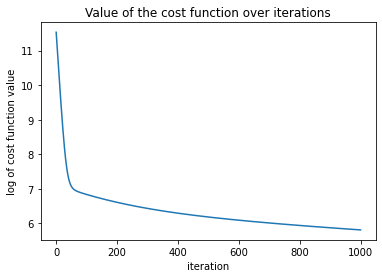

Coefficients:
 [[279.61588298]
 [ 50.06974749]
 [  8.2016622 ]
 [134.8553041 ]
 [118.0104882 ]]


In [10]:
coeffs = gradientDescent(X_train, y_train, w, m)
print("Coefficients:\n", coeffs)

We obtain the above plot where the convergence is very slow and the log of the cost function value is 
around 6 which is too much.

Let's take a bigger value of $\alpha$, for example 0.9. 

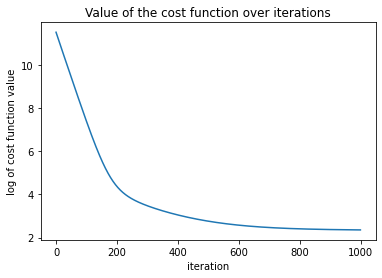

Coefficients:
 [[497.77351008]
 [-62.91443303]
 [-17.05837031]
 [  5.63294931]
 [ -8.85060912]]


In [11]:
coeffs = gradientDescent(X_train, y_train, w, m, alpha=0.9)
print("Coefficients:\n", coeffs)

The convergence is better and the log of the cost function is around 2.

## 2. Compare to Scikit-Learn

### 2.1. Functions to manage scores

To compare the accuracy of the different models, we implement three functions:
- meanAbsoluteError(params)
- rootMeanSquaredError(params)
- r2(params)
  
We use them as indicators to see if the model fits well to the data.

#### 2.1.1. Mean Absolute Error 

The Mean Absolute Error is a loss function which measures the average magnitude of error between $predicted$ and $observed$ values. 

$ MAE = \frac{\sum_{i=1}^{m} |\hat{y_i} - y_i|}{m} $ 

Our $predicted$ values vector is the product of $X$ and $w$ whereas the $observed$ values vector is $y$.

It gives us the following equation:
    
$ MAE = \frac{1}{m} \sum |Xw  - y| $

In [12]:
def meanAbsoluteError(X, y, w, m):
    return float(1 / m * sum(abs(X * w - y)))

#### 2.1.2. Root Mean Squared Error

The Root Mean Squarred Error is the standard deviation of the prediction errors.
It shows how concentrated our data is around the line of best fit.

$ RMSE = \sqrt{\frac{\sum_{i=1}^{m} (\hat{y_i} - y_i)^2}{m}}$

As we have seen with the cost function, we can use the transpose of the matrix 
$(predicted - observed)^T$ times itself to perform the sum of squares.

 $RMSE = \sqrt{\frac{1}{m}(Xw - y)^{T}(Xw - y)}$
 

In [13]:
def rootMeanSquaredError(X, y, w, m):
    return float(1 / m * (X * w - y).T * (X * w - y))**(1 / 2)

#### 2.1.3. R²

R² or coefficient of determination, is a statistical measure of how close the data are to the regression line.
It is always between 0 and 1 and indictes if the model explains all the response data or not. 
Higher R² is, better the model fits to the data.

$ R^2 = 1 - \frac{\sum_{i} (y_i - \hat{y_i})^2}{\sum_{i} (y_i - \bar{y_i})^2 } $

Once again, to build R² we reuse the transpose of the matrix times itself to perform the sum of squares.

$R^2 = 1 - \frac{(y - Xw)^T (y - Xw)}{(y- \bar{y})^T (y- \bar{y})} $ 


In [14]:
def r2(X, y, w):
    return float(1 - ((y - X * w).T * (y - X * w)) / ((y - y.mean()).T * (y - y.mean())))

### 2.2. Build a new linear model with Sckikit-Learn

Let's build a linear model using the $LinearRegression$ class from Scikit-Learn library.

We obtain the following result:

In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
coeffs_sklearn = model.coef_
coeffs_sklearn[0, 0] = model.intercept_
coeffs_sklearn = coeffs_sklearn.T
print("Coefficients:\n", coeffs_sklearn)

Coefficients:
 [[502.69911698]
 [-69.69967787]
 [-13.25083629]
 [  2.55340214]
 [-11.80117915]]


We have to replace the first value stored in coeffs_sklearn by the intercept 
because this first coefficient corresponds to the coefficient for the offset column with ones (which is useless). 

### 2.3. Compare linear models

We can compare our linear model to the one of Scikit-Learn library.

In [16]:
print("Our linear regression model:")
print("MAE:", meanAbsoluteError(X_train, y_train, coeffs, m))
print("RMSE:", rootMeanSquaredError(X_train, y_train, coeffs, m))
print("R2 train:", r2(X_train, y_train, coeffs))
print("R2 test:", r2(X_test, y_test, coeffs))

print("\nScikit-learn:")
print("MAE:", meanAbsoluteError(X_train, y_train, coeffs_sklearn, m))
print("RMSE:", rootMeanSquaredError(X_train, y_train, coeffs_sklearn, m))
print("R2 train:", r2(X_train, y_train, coeffs_sklearn))
print("R2 test:", r2(X_test, y_test, coeffs_sklearn))

Our linear regression model:
MAE: 3.6635489495679012
RMSE: 4.591269221035244
R2 train: 0.9276372771569878
R2 test: 0.9262444585124273

Scikit-learn:
MAE: 3.621062316914254
RMSE: 4.549440159271371
R2 train: 0.9289498016168694
R2 test: 0.9276525684728963


Comparing our scores with the ones of Scikit-learn, we remark that they are very close.  
Our MAE and RMSE are a bit higher and our R2 are a bit smaller than the ones of Scikit-Learn.
Looking at train and test results for R2 of both models, we see that test R2 are slightly smaller than train 
R2 as models are adjusted to train values. 

Moreover, the R2 of the train values of our model is slightly under the one of Scikit-Learn model, 
0.927 compare to 0.928. But it is fine as the gradient descent does not give the optimal 
coefficients. The algorithm would need to iterate indefinitely to get them.

## 3. Normal Equation

The normal equation calculates the optimal values for the weights:  
$ w = (X^T X)^{-1} .(X^T y) $

In [17]:
def normalEquation(X, y):
    return (X.T * X)**-1 * X.T * y

Let's compare the coefficients of the three models:

In [18]:
print("Our gradient descent:\n", coeffs)
print("\nScikit-learn:\n", coeffs_sklearn)
print("\nNormal equation:\n", normalEquation(X_train, y_train))

Our gradient descent:
 [[497.77351008]
 [-62.91443303]
 [-17.05837031]
 [  5.63294931]
 [ -8.85060912]]

Scikit-learn:
 [[502.69911698]
 [-69.69967787]
 [-13.25083629]
 [  2.55340214]
 [-11.80117915]]

Normal equation:
 [[502.69911698]
 [-69.69967787]
 [-13.25083629]
 [  2.55340214]
 [-11.80117915]]


As we can see, the result of our gradient descent did not reach the one of the normal equation, but we are close to it.

The results of Scikit-Learn and the normal equation are the same so we can suppose that 
Scikit-Learn uses the normal equation method to perform the linear regression.

## 4. Prediction

As R² is high (92.7 %) and MAE is under 3.7, our models fit well the data and we can make good predictions of the energy output: 

In [19]:
pred = pd.DataFrame(y_test, columns=["Observed"])
pred["Predicted"] = X_test * coeffs
print(pred)
print(pred.agg(["mean", "std"]))

      Observed   Predicted
0       470.21  470.442749
1       449.58  458.921141
2       489.07  487.872549
3       441.51  444.407619
4       468.33  462.449813
...        ...         ...
9563    440.99  440.056959
9564    446.75  448.997259
9565    436.99  440.464592
9566    464.95  462.373718
9567    432.09  433.725817

[9568 rows x 2 columns]
        Observed   Predicted
mean  454.619018  454.686918
std    17.058193   16.294827


By comparing the $observed$ and $predicted$ PE values, we see that the $predicted$ are very close to the $observed$ ones. 
In fact, when we look at the mean and standard deviation, there is a difference between them which is under 0.07 for the mean 
and 0.76 for the standard deviation.  
So given values of temperature, vacuum, pressure and humidity, we can predict accurately the energy output.

## Conclusion

This first lab allowed us to familiarize with the implementation of a linear regression model from scratch
and using Scikit-Learn library.  
As we will reuse our implementation, we decided to create a class implementing our linear regression model in the file **linreg.py**.

